# N1 Health Take Home Data Challenge

By: Ophelia Sin

Last Updated: February 17, 2025

## Summary

Data Preparation:
- Utilized two main datasets: CDC's 500 Cities Project and FDA's Food Atlas
- Cleaned and merged datasets using FIPS codes as the joining key
- Handled data quality issues, including 38 records with NA values in food access data

Key Variables Selected:
1. Health Indicators:
- Arthritis, COPD, High Blood Pressure, Heart Disease prevalence
- Focused on conditions relevant to senior population

2. Food Access Metrics:
- Senior food access (LACCESS_SENIORS15)

Analysis Approach:
- Created composite scores combining health and food access indicators
- Identified high-need areas based on the composite score

Visualization Development:
- Developed choropleth maps displaying state-level composite scores
- Generated bar charts showing coverage metrics at key percentile thresholds

Key Findings:
- Identified strong correlations between food access and health conditions:
  * Arthritis (0.333 correlation)
  * COPD (0.296 correlation)
  * High Blood Pressure (0.228 correlation)
- Found geographic patterns in food access challenges
- Quantified potential program impact at different coverage levels
  - At the 25th percentile, we are covering 3.6 million seniors, 6803 tracts, 352 cities, and 47 states.
  - At the 50th percentile , we are covering 3.9 million seniors, 10884 tracts, 455 cities, and 50 states.

# Data Exploration

First, I explored the datasets I was provided.

In [2]:
import sqlite3
import pandas as pd

In [3]:
conn = sqlite3.connect('challenge.db')

In [4]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)

                  name
0  five_hundred_cities
1               access
2        variable_list


In [5]:
five_hundred_cities = pd.read_sql_query("SELECT * FROM five_hundred_cities", conn)

In [6]:
# we'll only keep the model based estimates for the analysis to make initial recommendations. 
# keeping only columns that are related to food access (using domain knowledge)
five_hundred_cities = five_hundred_cities[[
    'StateAbbr',          # State Abbreviation
    'PlaceName',          # City/Place Name
    'PlaceFIPS',          # Place FIPS Code
    'TractFIPS',          # Census Tract FIPS Code
    'Place_TractID',      # Place and Tract ID Combined
    'Population2010',     # Population Count from 2010 Census
    'ACCESS2_CrudePrev',  # Crude Prevalence of Current Lack of Health Insurance Access
    'ARTHRITIS_CrudePrev',# Crude Prevalence of Arthritis
    'BPHIGH_CrudePrev',   # Crude Prevalence of High Blood Pressure
    'BPMED_CrudePrev',    # Crude Prevalence of Blood Pressure Medication Use
    'CANCER_CrudePrev',   # Crude Prevalence of Cancer (excluding skin cancer)
    'CASTHMA_CrudePrev',  # Crude Prevalence of Current Asthma
    'CHD_CrudePrev',      # Crude Prevalence of Coronary Heart Disease
    'COPD_CrudePrev',     # Crude Prevalence of COPD (Chronic Obstructive Pulmonary Disease)
    'COREM_CrudePrev',    # Crude prevalence of older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening
    'COREW_CrudePrev',    # Crude prevalence of older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening
    'DIABETES_CrudePrev', # Crude Prevalence of Diabetes
    'HIGHCHOL_CrudePrev', # Crude Prevalence of High Cholesterol
    'KIDNEY_CrudePrev',   # Crude Prevalence of Chronic Kidney Disease
    'LPA_CrudePrev',      # Crude Prevalence of No Leisure-time Physical Activity
    'MHLTH_CrudePrev',    # Crude Prevalence of Poor Mental Health
    'OBESITY_CrudePrev',  # Crude Prevalence of Obesity
    'PHLTH_CrudePrev',    # Crude Prevalence of Poor Physical Health
    'STROKE_CrudePrev',   # Crude Prevalence of Stroke
    'TEETHLOST_CrudePrev',# Crude Prevalence of All Teeth Lost (aged ≥65 years)
    'Geolocation'         # Geographic Location Coordinates
]]

In [7]:
five_hundred_cities['TractFIPS'] = five_hundred_cities['TractFIPS'].astype(str).str.zfill(11)

# # extract first 5 digits for SS + CCC
five_hundred_cities['FIPS'] = five_hundred_cities['TractFIPS'].str[:5]

# convert back to int
five_hundred_cities['FIPS'] = five_hundred_cities['FIPS'].astype(int)

In [8]:
access_df = pd.read_sql_query("select * from access", conn)

In [9]:
#  for FIPS that are not 5 digits, we will need to pad with leading 0s
# convert FIPS to string and pad with leading 0s
access_df['FIPS'] = access_df['FIPS'].astype(str)
access_df['FIPS'] = access_df['FIPS'].str.zfill(5)
access_df['FIPS'] = access_df['FIPS'].astype(int)

In [10]:
# use the most recent data
# remove columns taht aren't related to seniors, low income, or households with no car

access_df = access_df[[
'FIPS',                     
'State',                    
'County',                    
'LACCESS_SENIORS15',         # Count of seniors with low access to store
'PCT_LACCESS_SENIORS15',     # Percentage of seniors with low access to store
'LACCESS_HHNV15',           # Count of households with no car and low access to store
'PCT_LACCESS_HHNV15',       # Percentage of households with no car and low access to store
'LACCESS_LOWI15',           # Count of low income population with low access to store
'PCT_LACCESS_LOWI15',       # Percentage of low income population with low access to store
'LACCESS_POP15',            # Count of population with low access to store
'PCT_LACCESS_POP15',        # Percentage of population with low access to store
'LACCESS_WHITE15',          # Count of White population with low access to store
'PCT_LACCESS_WHITE15',      # Percentage of White population with low access to store
'LACCESS_BLACK15',          # Count of Black population with low access to store
'PCT_LACCESS_BLACK15',      # Percentage of Black population with low access to store
'LACCESS_HISP15',           # Count of Hispanic ethnicity population with low access to store
'PCT_LACCESS_HISP15',       # Percentage of Hispanic ethnicity population with low access to store
'LACCESS_NHASIAN15',        # Count of Asian population with low access to store
'PCT_LACCESS_NHASIAN15',    # Percentage of Asian population with low access to store
'LACCESS_NHNA15',           # Count of American Indian or Alaska Native population with low access to store
'PCT_LACCESS_NHNA15',       # Percentage of American Indian or Alaska Native population with low access to store
'LACCESS_NHPI15',           # Count of Hawaiian or Pacific Islander population with low access to store
'PCT_LACCESS_NHPI15',       # Percentage of Hawaiian or Pacific Islander population with low access to store
'LACCESS_MULTIR15',         # Count of Multiracial population with low access to store
'PCT_LACCESS_MULTIR15'      # Percentage of Multiracial population with low access to store
]]


In [11]:
# join the two dataframes on FIPS
merged_df = pd.merge(five_hundred_cities, access_df, on='FIPS', how='left')

### Data quality checks

I found that the food access data points had 38 records with NA values. I ignored  `COREW_CrudePrev`, `COREM_CrudePrev` and `TEETHLOST_CrudePrev` as they were not relevant to this analysis.

In [12]:
# check if there are any missing values
merged_df.isnull().sum().sort_values(ascending=False)

COREW_CrudePrev          109
COREM_CrudePrev          103
TEETHLOST_CrudePrev       60
PCT_LACCESS_MULTIR15      38
PCT_LACCESS_SENIORS15     38
LACCESS_HHNV15            38
PCT_LACCESS_HHNV15        38
LACCESS_LOWI15            38
PCT_LACCESS_LOWI15        38
LACCESS_POP15             38
PCT_LACCESS_POP15         38
LACCESS_WHITE15           38
PCT_LACCESS_WHITE15       38
LACCESS_BLACK15           38
PCT_LACCESS_BLACK15       38
LACCESS_HISP15            38
PCT_LACCESS_HISP15        38
LACCESS_NHASIAN15         38
PCT_LACCESS_NHASIAN15     38
LACCESS_NHNA15            38
PCT_LACCESS_NHNA15        38
LACCESS_NHPI15            38
PCT_LACCESS_NHPI15        38
LACCESS_MULTIR15          38
LACCESS_SENIORS15         38
ACCESS2_CrudePrev          1
County                     0
StateAbbr                  0
State                      0
CHD_CrudePrev              0
PlaceFIPS                  0
TractFIPS                  0
Place_TractID              0
Population2010             0
ARTHRITIS_Crud

In [13]:
merged_df[merged_df['PCT_LACCESS_SENIORS15'].isnull()]

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
25773,VA,Alexandria,5101000,51510200102,5101000-51510200102,4429,20.8,17.8,25.7,66.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25774,VA,Alexandria,5101000,51510200103,5101000-51510200103,7151,19.1,19.6,28.9,68.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25775,VA,Alexandria,5101000,51510200104,5101000-51510200104,3963,23.8,15.1,23.9,59.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25776,VA,Alexandria,5101000,51510200105,5101000-51510200105,3777,15.2,19.5,30.5,69.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25777,VA,Alexandria,5101000,51510200106,5101000-51510200106,3176,14.5,25.5,31.6,77.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25778,VA,Alexandria,5101000,51510200107,5101000-51510200107,5766,9.9,13.2,18.1,59.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25779,VA,Alexandria,5101000,51510200201,5101000-51510200201,3571,9.1,16.9,21.4,67.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25780,VA,Alexandria,5101000,51510200202,5101000-51510200202,1572,5.5,26.3,30.5,79.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25781,VA,Alexandria,5101000,51510200301,5101000-51510200301,3103,13.2,14.9,21.2,63.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25782,VA,Alexandria,5101000,51510200302,5101000-51510200302,4222,15.3,21.1,28.4,71.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I did also find a number of counties that had 0 seniors experiencing low access. If I have more time on this analysis, I would further investigate this. For now, I'm assuming this wouldn't be a problem.

In [14]:
access_df[access_df['LACCESS_SENIORS15'] == 0]

,FIPS,State,County,LACCESS_SENIORS15,PCT_LACCESS_SENIORS15,LACCESS_HHNV15,PCT_LACCESS_HHNV15,LACCESS_LOWI15,PCT_LACCESS_LOWI15,LACCESS_POP15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
268,8047,CO,Gilpin,0.0,0.0,134.721886,5.476499,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
548,15005,HI,Kalawao,0.0,0.0,12.000000,17.391304,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
770,18147,IN,Spencer,0.0,0.0,174.690660,2.161478,0.368442,0.001759,2.095516,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1045,21105,KY,Hickman,0.0,0.0,98.782416,4.870928,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1471,28141,MS,Tishomingo,0.0,0.0,315.842936,3.876325,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1858,36061,NY,New York,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,2.0,0.000126,0.0,0.0,0.0,0.0,0.0,0.0
2456,47057,TN,Grainger,0.0,0.0,336.494079,3.726814,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2735,48425,TX,Somervell,0.0,0.0,25.656078,0.833531,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2858,51079,VA,Greene,0.0,0.0,270.489045,3.989514,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2876,51115,VA,Mathews,0.0,0.0,129.500712,3.356680,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation Matrix

In [15]:
numerical_cols = merged_df.select_dtypes(include=['number']).columns # select numerical columns
numerical_cols

columns_to_drop = ['PlaceFIPS', 'FIPS'] # filter out categorical columns
filtered_numerical_cols = numerical_cols.drop(['PlaceFIPS', 'FIPS'])


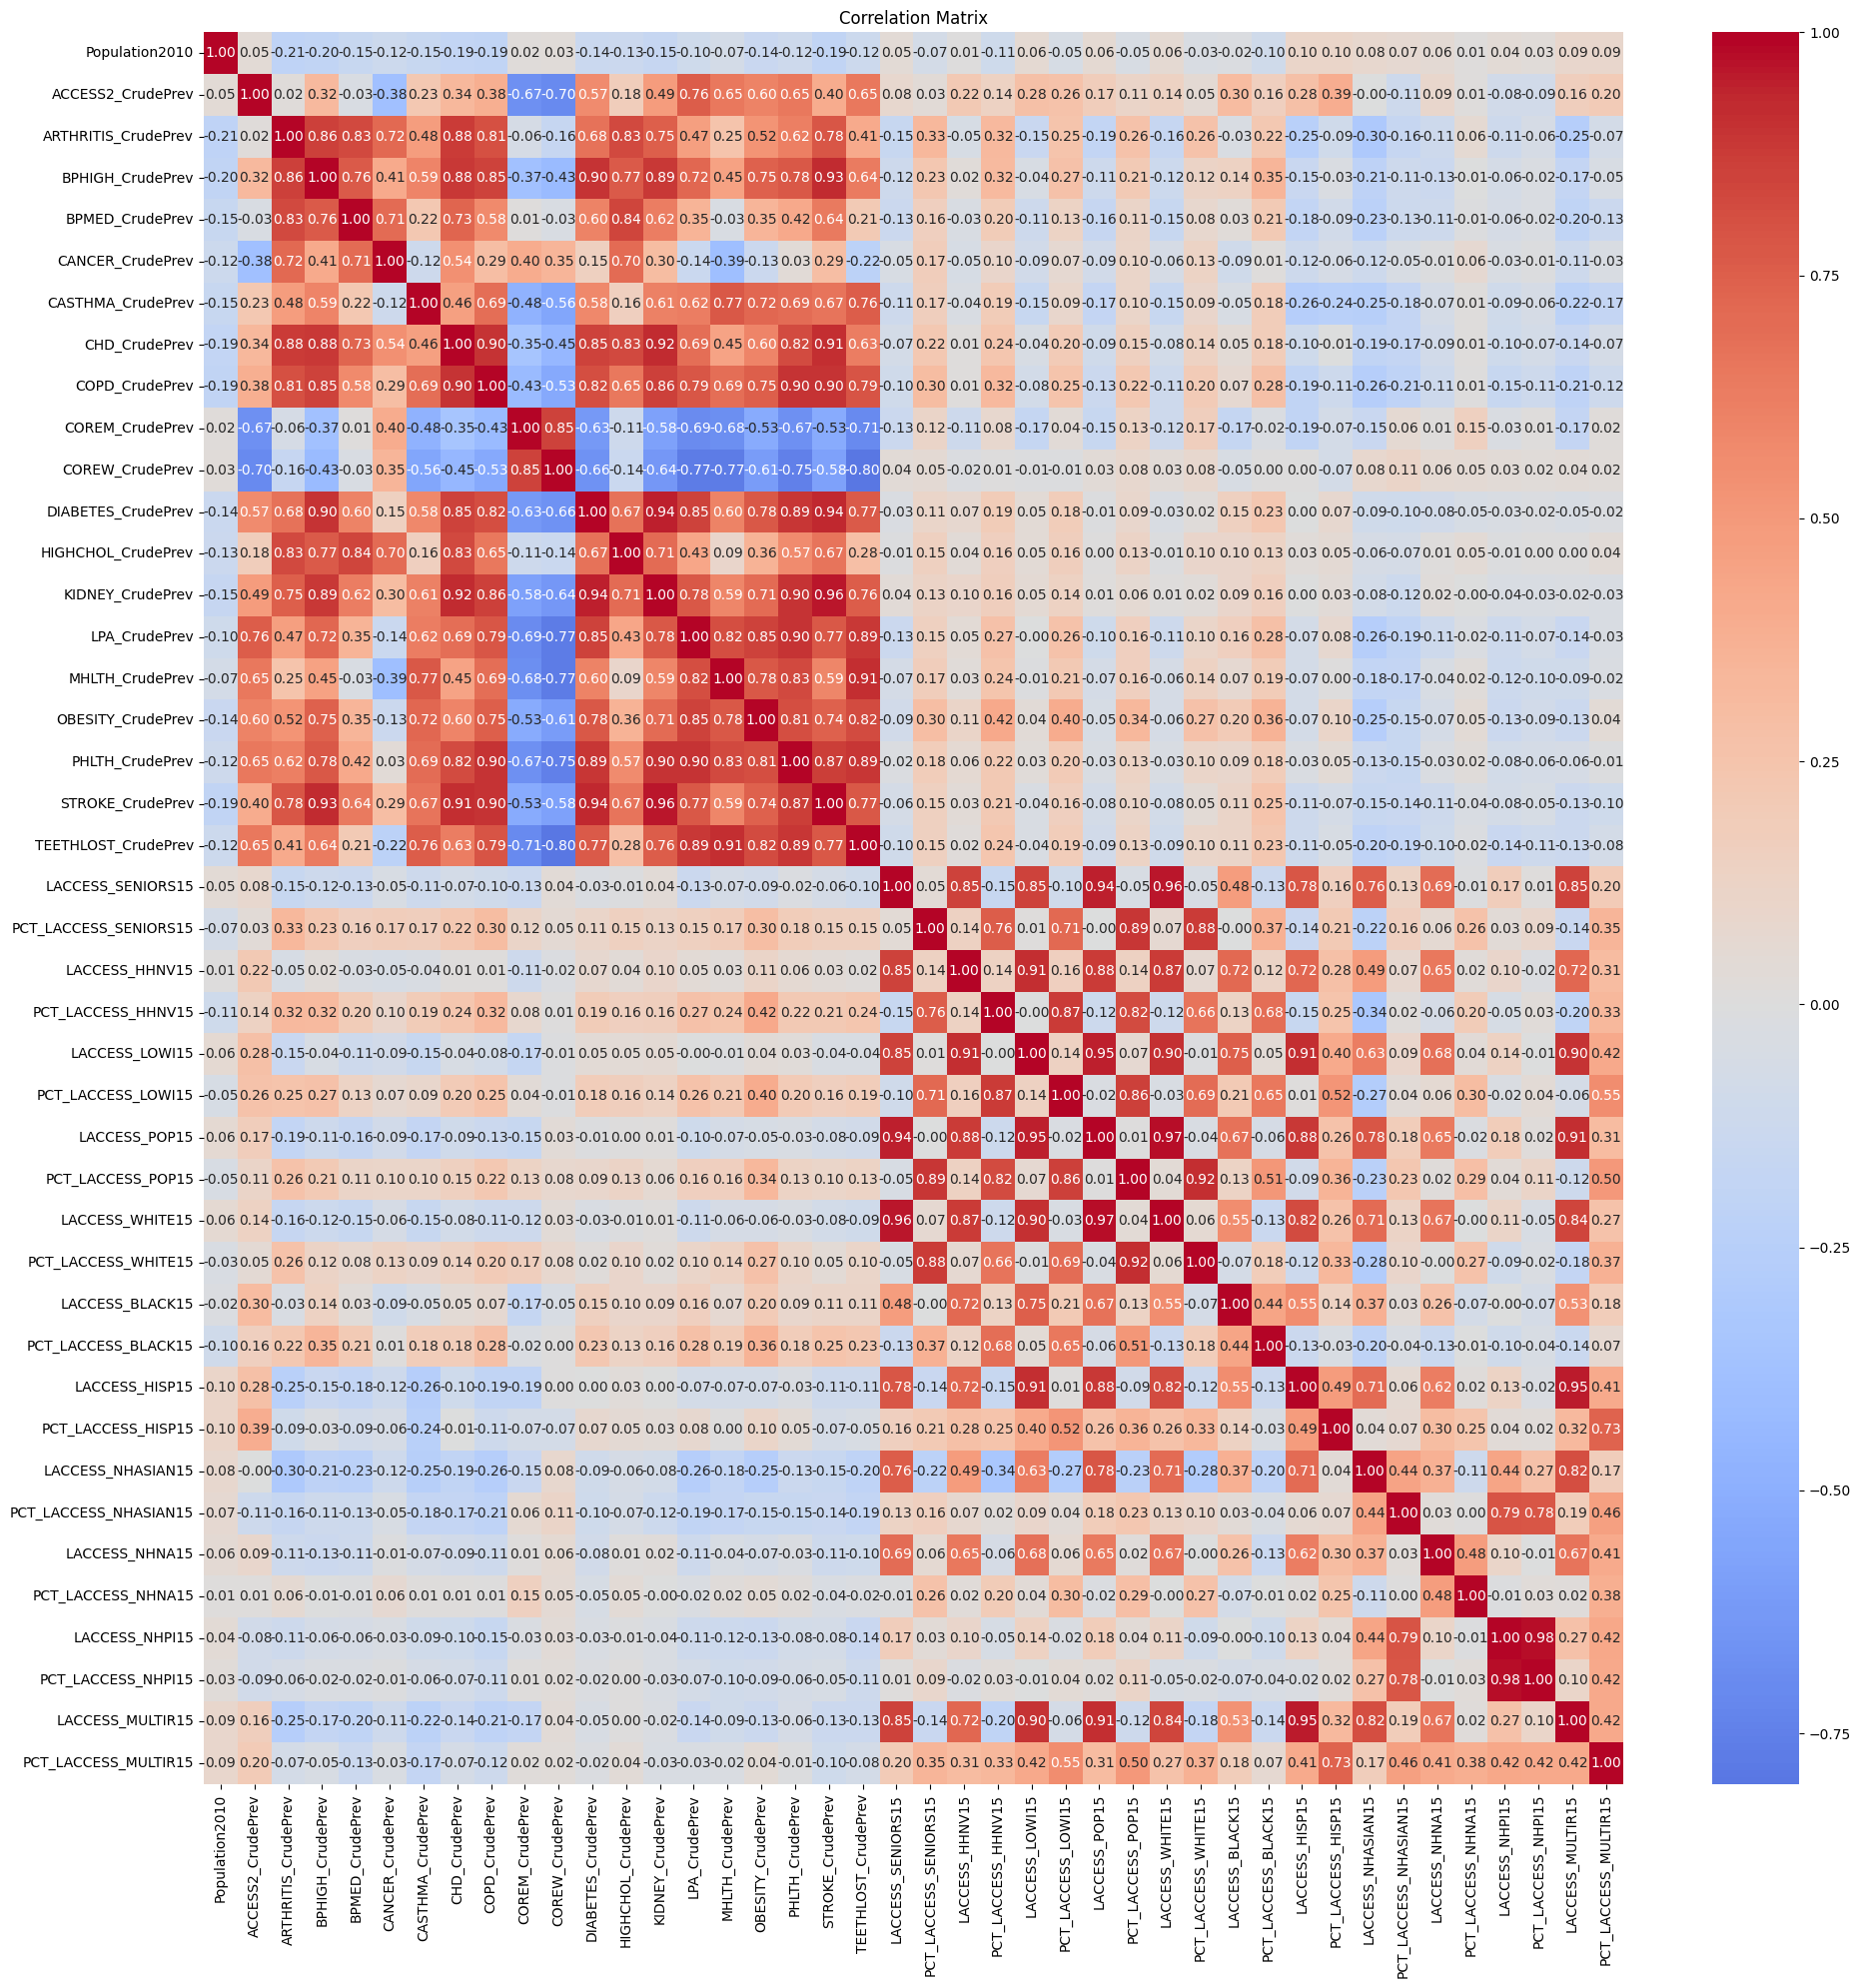

In [16]:
# Correlation matrix for all continuous variables
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix_numerical = merged_df[filtered_numerical_cols].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_numerical, 
            annot=True,  
            cmap='coolwarm', 
            center=0, 
            fmt='.2f') 
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

The matrix reveals 4 moderate positive correlation between health indicators (like arithitis, high BP, COPD, and Obesity) and low access to grocery store amongst seniors, low-income, have no car and overall population wide low access.  
- We know that unhealthy diet is one of the major causes for high BP
- Obesity creates higher risk for high BP 
- Age and weight increase risk for arthritis 
- COPD – isn't caused by lack of a nutritious diet, but the condition makes it difficult for people to access grocery stores regularly


Here are some other observations:

- Population size plays no role in health outcomes (perhaps because all of these are 'cities'?)
- Lack of health insurance (18-64) could be larger symptom of not having the awareness to get health insurance (even those whoare are 65+)
    - positively correlated with multiple chronic diseases
- lots of comorbidity (except for cancer)
- negative correlation between 65+ who are up-to-date with regular preventative screenings and other chronic conditions 
- Under food access
    - all the counts are positively correlated to one another, and all the percentages are also positively correlated to one another 
        - likely that seniors that are low income + have no car will have low access to food stores

- food access specific to race
    - high positive correlation between low access count in seniors and low access count amongst white,  hispanic, asian, and american indian/ alaskan native, and multiracial (except Hawaiian or Pacific Islander)
    - similar trend with the percentage, but hispanic, black, asian percentages have weaker correlation with senior percentage

## Descriptive Statistics 

### Boxplots

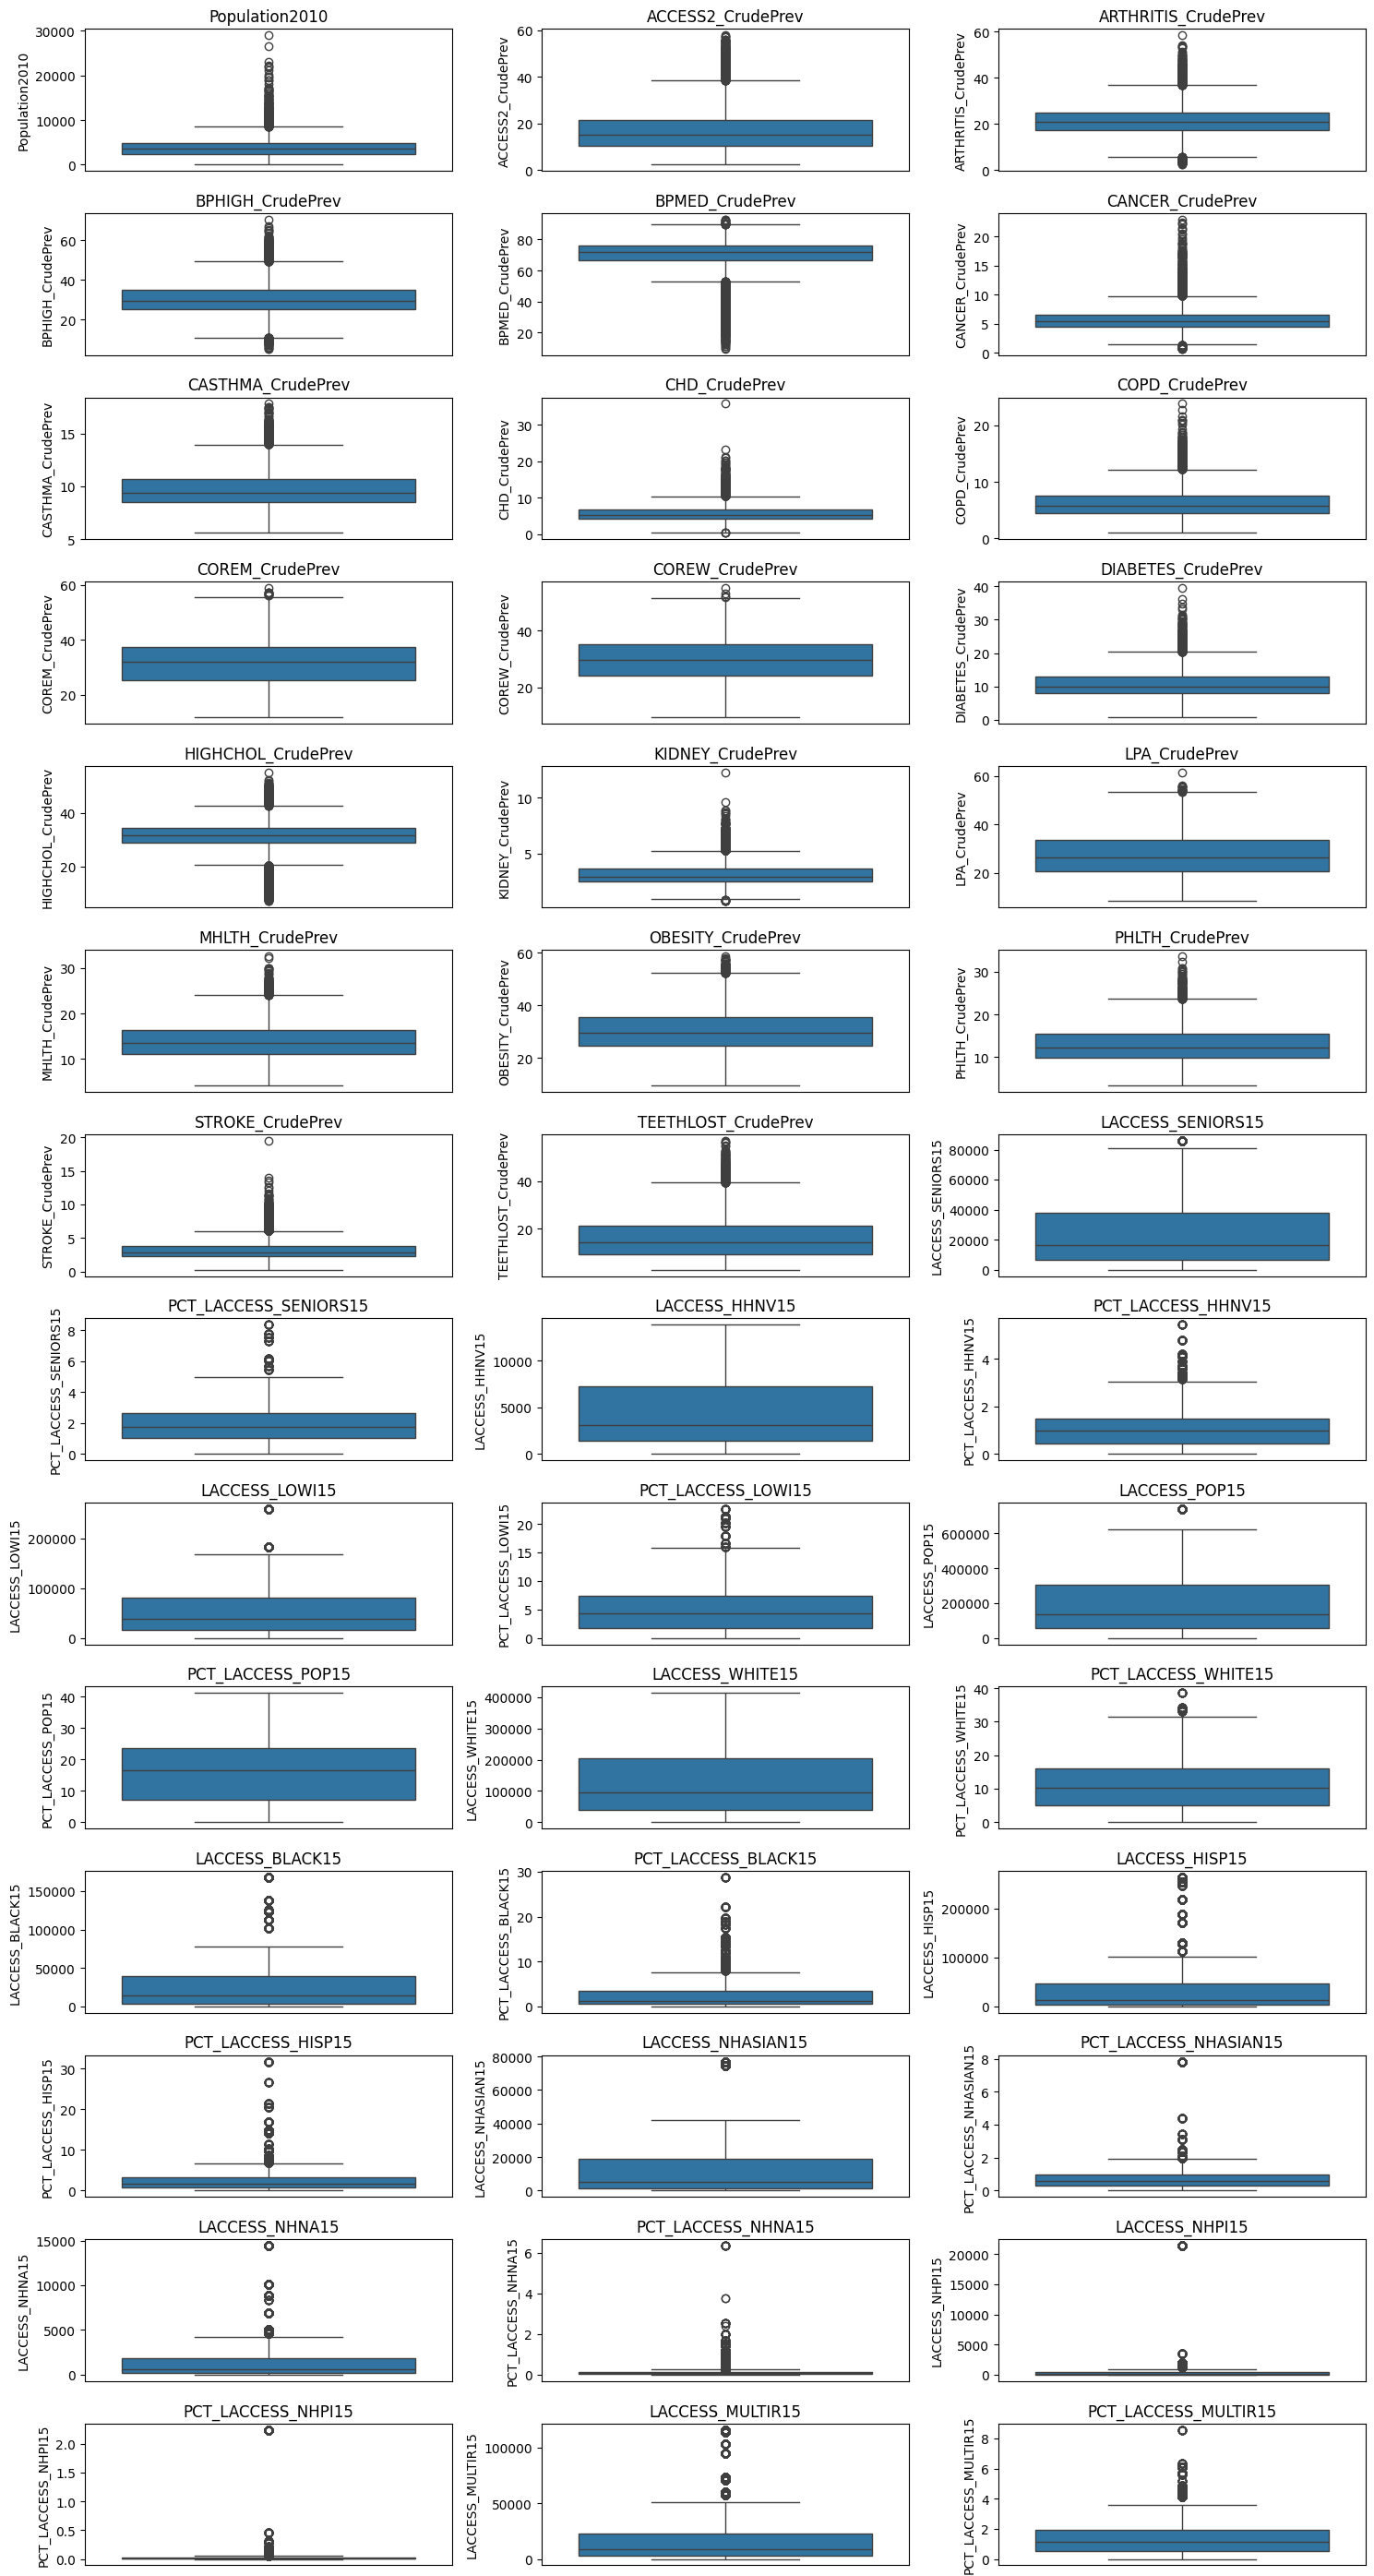

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


def create_boxplot(df, columns, figsize=(15,30)):
    n_rows = len(columns) * 3
    
    plt.figure(figsize=figsize)
    
    for i, column in enumerate(columns, 1):
        plt.subplot(len(columns)//3 + 1, 3, i)
        sns.boxplot(y=df[column])
        plt.title(column)
        plt.xticks([])
        
    plt.tight_layout()
    plt.show()

create_boxplot(merged_df, filtered_numerical_cols)


- We see outliers for the percentages of low access to grocery stores amongst seniors, people who don't own cars, and in general.

### Histograms

In [18]:
def create_histograms(df, columns, figsize=(15, 50)):
    # Create subplots with specific number of rows and columns
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=figsize)
    
    # Create histogram for each column
    for i, column in enumerate(columns):
        sns.histplot(data=df[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')
    
    plt.tight_layout()
    plt.show()

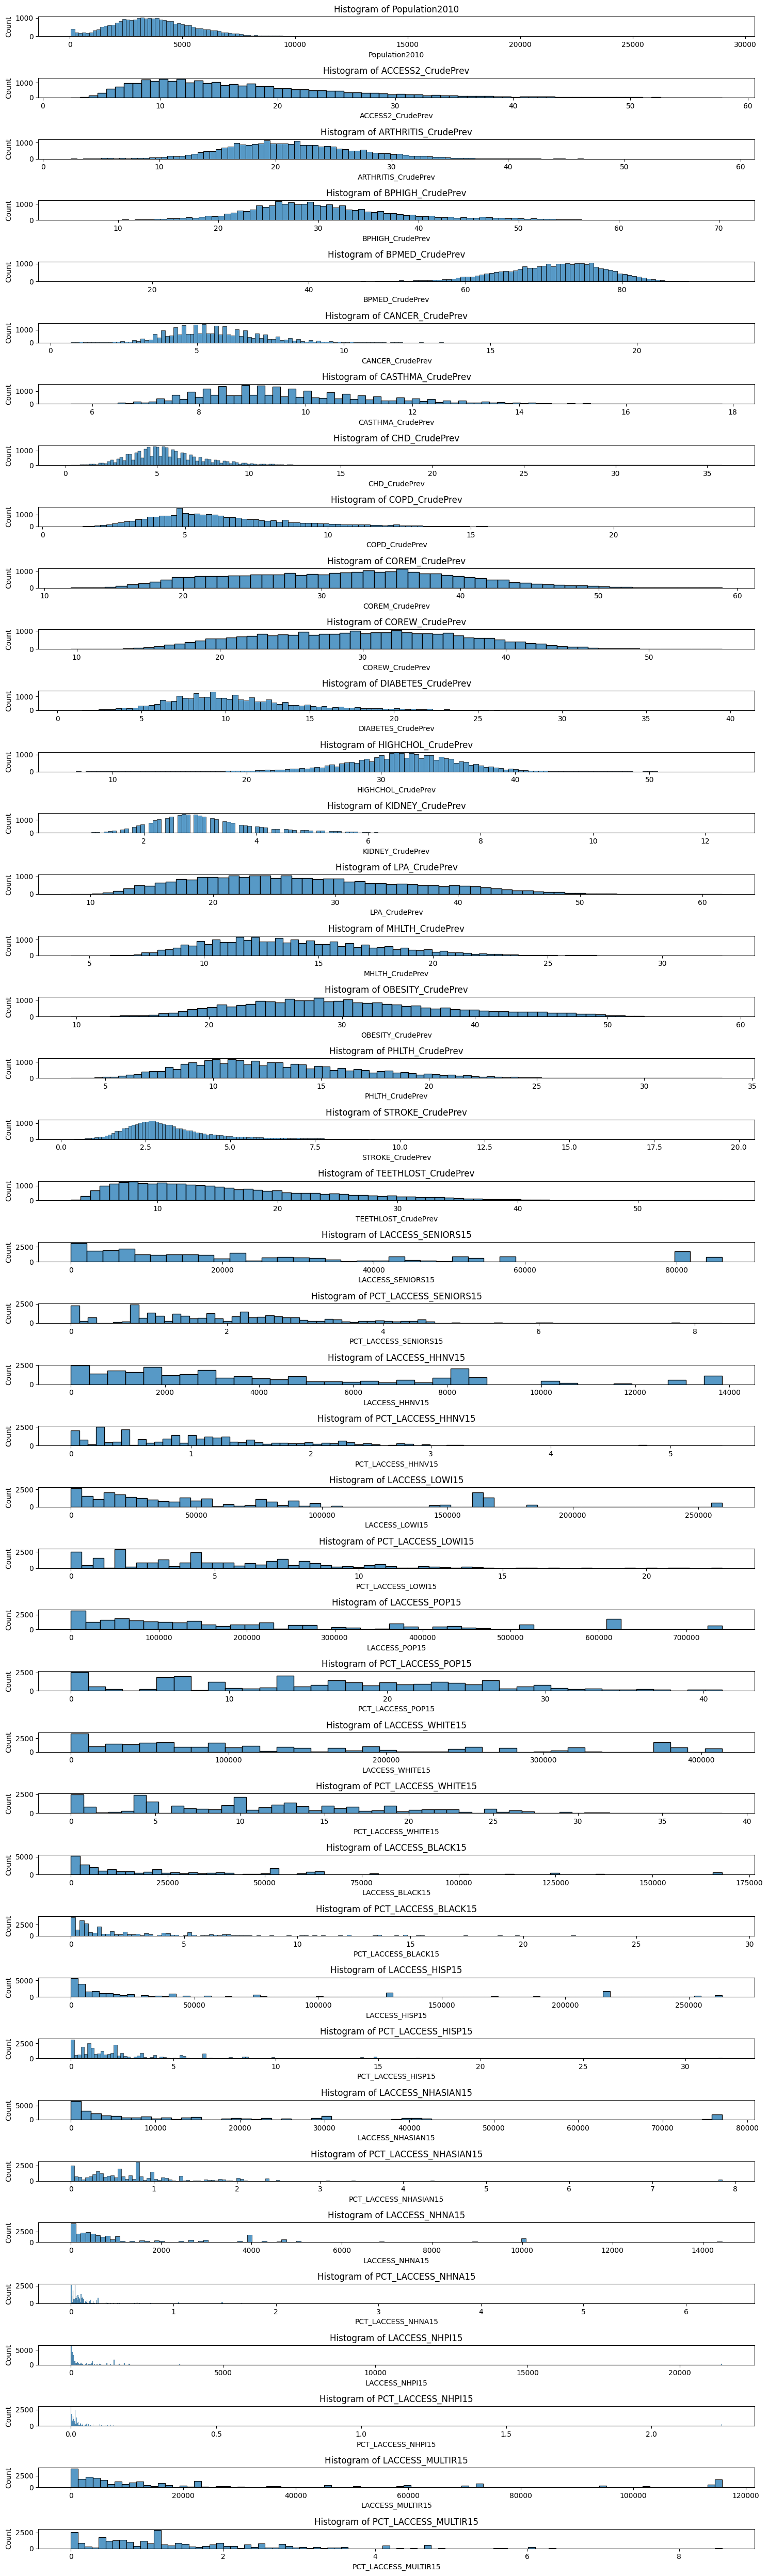

In [19]:
create_histograms(merged_df, filtered_numerical_cols)

# Data Cleaing

### Impute missing values in access_df based on median of state
- I chose to use the median because it's less sensitive to outliers
- If I had more time on the project I would use data from the nearest counties to impute the value, but that would require more calculations.
- This method does pose some limitation because counties from two different states can border one another, so we're missing important data points for imputation. 

In [20]:
# Access columns from 2015
columns_to_impute = ['LACCESS_SENIORS15',         # Count of seniors with low access to store
'PCT_LACCESS_SENIORS15',     # Percentage of seniors with low access to store
'LACCESS_HHNV15',           # Count of households with no car and low access to store
'PCT_LACCESS_HHNV15',       # Percentage of households with no car and low access to store
'LACCESS_LOWI15',           # Count of low income population with low access to store
'PCT_LACCESS_LOWI15',       # Percentage of low income population with low access to store
'LACCESS_POP15',            # Count of population with low access to store
'PCT_LACCESS_POP15',        # Percentage of population with low access to store
'LACCESS_WHITE15',          # Count of White population with low access to store
'PCT_LACCESS_WHITE15',      # Percentage of White population with low access to store
'LACCESS_BLACK15',          # Count of Black population with low access to store
'PCT_LACCESS_BLACK15',      # Percentage of Black population with low access to store
'LACCESS_HISP15',           # Count of Hispanic ethnicity population with low access to store
'PCT_LACCESS_HISP15',       # Percentage of Hispanic ethnicity population with low access to store
'LACCESS_NHASIAN15',        # Count of Asian population with low access to store
'PCT_LACCESS_NHASIAN15',    # Percentage of Asian population with low access to store
'LACCESS_NHNA15',           # Count of American Indian or Alaska Native population with low access to store
'PCT_LACCESS_NHNA15',       # Percentage of American Indian or Alaska Native population with low access to store
'LACCESS_NHPI15',           # Count of Hawaiian or Pacific Islander population with low access to store
'PCT_LACCESS_NHPI15',       # Percentage of Hawaiian or Pacific Islander population with low access to store
'LACCESS_MULTIR15',         # Count of Multiracial population with low access to store
'PCT_LACCESS_MULTIR15'     # Percentage of Multiracial population with low access to store
]

merged_df[columns_to_impute] = merged_df[columns_to_impute].fillna(merged_df.groupby('State')[columns_to_impute].transform('median'))


In [21]:
five_hundred_cities.describe() #check to verify that the imputation worked

,PlaceFIPS,Population2010,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,COPD_CrudePrev,...,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,KIDNEY_CrudePrev,LPA_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PHLTH_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev,FIPS
count,2.721000e+04,27210.000000,27209.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,...,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27150.000000,27210.000000
mean,2.605539e+06,3785.703087,16.990915,21.430129,30.653208,70.744274,5.648912,9.741352,5.602977,6.309960,...,10.811062,31.364296,3.099666,27.593671,13.921040,30.472922,12.882962,3.211466,16.108107,25862.715913
std,1.681206e+06,1944.825182,8.869361,5.995361,8.260472,7.927116,1.803257,1.710538,2.118858,2.545739,...,4.269441,4.887047,0.960904,8.830258,3.617324,8.180685,4.011045,1.449541,8.780165,16717.533247
min,1.500300e+04,50.000000,2.400000,2.400000,5.300000,9.600000,0.700000,5.600000,0.300000,1.000000,...,0.800000,6.900000,0.700000,8.400000,4.200000,9.600000,3.400000,0.300000,2.800000,1073.000000
25%,6.815540e+05,2457.250000,10.300000,17.300000,25.300000,66.700000,4.500000,8.500000,4.200000,4.500000,...,7.900000,28.800000,2.500000,20.700000,11.200000,24.500000,9.900000,2.300000,9.200000,8001.000000
50%,2.622000e+06,3611.000000,15.000000,21.000000,29.500000,71.700000,5.500000,9.400000,5.300000,5.800000,...,10.000000,31.700000,2.900000,26.500000,13.500000,29.500000,12.300000,2.900000,14.100000,26077.000000
75%,4.052500e+06,4900.000000,21.600000,25.100000,34.900000,75.900000,6.600000,10.700000,6.700000,7.600000,...,12.900000,34.400000,3.600000,33.800000,16.400000,35.600000,15.400000,3.800000,21.300000,40109.000000
max,5.613900e+06,28960.000000,57.800000,58.400000,70.300000,92.800000,22.900000,17.800000,35.800000,23.800000,...,39.500000,55.400000,12.300000,61.600000,32.600000,58.600000,33.600000,19.500000,57.000000,56021.000000


In [22]:
# assuming that these counties have really great food access for seniors (but would need more investigation if time permits)

access_df[access_df['LACCESS_SENIORS15'] == 0]

,FIPS,State,County,LACCESS_SENIORS15,PCT_LACCESS_SENIORS15,LACCESS_HHNV15,PCT_LACCESS_HHNV15,LACCESS_LOWI15,PCT_LACCESS_LOWI15,LACCESS_POP15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
268,8047,CO,Gilpin,0.0,0.0,134.721886,5.476499,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
548,15005,HI,Kalawao,0.0,0.0,12.000000,17.391304,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
770,18147,IN,Spencer,0.0,0.0,174.690660,2.161478,0.368442,0.001759,2.095516,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1045,21105,KY,Hickman,0.0,0.0,98.782416,4.870928,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1471,28141,MS,Tishomingo,0.0,0.0,315.842936,3.876325,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1858,36061,NY,New York,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,2.0,0.000126,0.0,0.0,0.0,0.0,0.0,0.0
2456,47057,TN,Grainger,0.0,0.0,336.494079,3.726814,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2735,48425,TX,Somervell,0.0,0.0,25.656078,0.833531,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2858,51079,VA,Greene,0.0,0.0,270.489045,3.989514,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2876,51115,VA,Mathews,0.0,0.0,129.500712,3.356680,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# Assumptions

Here are some assumptions I established before further going into the analysis:
1. Since low access rate amongst elderly is highly correlated with low access amongst people who don't own cars and those who are in the low-income bracket, it's safe to assume that an effective food access program should provide meal delivery rather than grocery vouchers to its participants.
2. Funding is limited in this program. The Medicare Advantage program prioritizes rolling out to areas with the most need. 
3. Food access doesn't just mean access to any food. It means access to nutritious food that can potentially improve health outcomes. 

# 1. Where should we deploy a food access program? (Suitability Analysis)

To decide where to deploy the food access program, I decided to create a composite score that quanitifies health indicators that are moderately correlated with low access amongst elderly populations.

The health composite score includes health indicators that are moderately correlated to low food access amongst the elderly population.

- Moderate positive correlation with low food access percentage amongst elderly
    - ARTHRITIS_CrudePrev (0.333)
    - COPD_CrudePrev (0.296)
    - BPHIGH_CrudePrev (High Blood Pressure) (0.228)
    - CHD_CrudePrev (Coronary Heart Disease) (0.220)

Other correlations worth mentioning:

- Weak Positive Correlations (0.1-0.2):
    - CASTHMA_CrudePrev (Asthma) (0.167)
    - BPMED_CrudePrev (Blood Pressure Medication) (0.162)
    - CANCER_CrudePrev (0.172)

- Comorbidity: 
    - High Blood Pressure (BPHIGH):
        -  Diabetes (0.899)
        -  Coronary Heart Disease (0.881)
        - Stroke (0.929)
        -  Kidney Disease (0.885)
        -  COPD (0.852)
        -  Arthritis (0.859)
    - Coronary Heart Disease (CHD):
        -  COPD (0.900)
        -  Stroke (0.910)
        -  Kidney Disease (0.918)
        -  Arthritis (0.877)
    - Diabetes (DIABETES):
        -  Kidney Disease (0.944)
        -  Stroke (0.935)
        -  Physical Health Issues (0.894)
    - COPD:
        -  Stroke (0.901)
        -  Physical Health Issues (0.896)
        -  Kidney Disease (0.861)

Weakly positively correlated variables and comorbidities were not included in this specific analysis, but are worth exploring incorporating when time permits.

I multiplied all the moderately correlated variables together (and divided each of them by 100) to create a health score.

In [81]:
merged_df['health_score'] = merged_df['ARTHRITIS_CrudePrev'] / 100 * merged_df['COPD_CrudePrev'] / 100 * merged_df['BPHIGH_CrudePrev'] / 100 * merged_df['CHD_CrudePrev'] / 100 

Then I multiplied the low access rate amongst seniors to arrive to a final composite score that encompasses the health and accessibility impact. A high composite score indicates the area that has the greatest need for intervention.

In [83]:
merged_df['composite_score'] = merged_df['health_score'] * merged_df['PCT_LACCESS_SENIORS15']

In [84]:
merged_df['composite_score'].describe()

count    27210.000000
mean         0.000925
std          0.001989
min          0.000000
25%          0.000081
50%          0.000280
75%          0.000911
max          0.068551
Name: composite_score, dtype: float64

## Converting composite scores to percentiles

Here I converted the composite scores to percentiles for visualization to non-technical stakeholders.

In [91]:
coverage_stats = []


for p in range(0, 105, 5):
    # Get score threshold for this percentile
    score_threshold = merged_df['composite_score'].quantile(p/100)
    
    # Filter tracts meeting threshold
    covered_tracts = merged_df[merged_df['composite_score'] >= score_threshold]
    
    seniors_covered = covered_tracts.groupby('FIPS')['LACCESS_SENIORS15'].first().sum()

    # Calculate statistics
    stats = {
        'Percentile': p,
        'Score_Threshold': score_threshold,
        'Tracts_Covered': len(covered_tracts),
        'Seniors_Covered': seniors_covered,
        'Cities_Covered': covered_tracts['PlaceFIPS'].nunique(),
        'States_Covered': covered_tracts['StateAbbr'].nunique()
    }
    
    coverage_stats.append(stats)

# Convert to DataFrame
coverage_df = pd.DataFrame(coverage_stats)

coverage_df['reversed_percentile'] = 100 - coverage_df['Percentile'] # reversed the percentile for easier interpretation
coverage_df['Seniors_Covered'] = coverage_df['Seniors_Covered'].apply(lambda x: '{:.0f}'.format(x))

In [92]:
coverage_df

,Percentile,Score_Threshold,Tracts_Covered,Seniors_Covered,Cities_Covered,States_Covered,reversed_percentile
0,0,0.000000,27210,3943811,500,51,100
1,5,0.000001,25849,3943811,500,51,95
2,10,0.000012,24489,3941533,500,51,90
3,15,0.000036,23128,3941102,499,51,85
4,20,0.000059,21768,3941102,498,51,80
5,25,0.000081,20407,3939394,497,51,75
6,30,0.000107,19047,3931592,491,51,70
7,35,0.000139,17686,3931592,483,51,65
8,40,0.000178,16326,3931592,477,51,60
9,45,0.000223,14965,3917837,465,51,55


Conclusion: 

We want to prioritize areas that have a high composite score. Depending on the funding allocated, we can slowly expand to more areas. 

We would want to test it out in a few selected areas of varying scores to see how effective the program is in improving selected health outcomes, since the correlation is moderately positive (not strongly).

Our ultimate goal can be to target tracts that have a positive composite score which indicate these are areas of priority areas for intervention. This encompasses 417/500 cities. 

# 2.	How many people will be included? How many might be successfully engaged?

- 3.94 million seniors that are currently struggling with low access to grocery stores will be included in this program, assuming the program is expanded nation wide. 

- According to [KFF](https://www.kff.org/medicare/issue-brief/medicare-advantage-in-2024-enrollment-update-and-key-trends/#:~:text=More%20than%20half%20(54%25),from%202%25%20to%2063%25), in 2024 54% of eligble Medicare beneficiaries are enrolled in Medicare Advantage. 
    - If 54% of seniors struggling with food access get Medicare Advantage and use our plan, an optimistic and general upper limit estimate would yield us 3.94 million * 0.54 = 2.13 million participants

I define 'successfully engaged' as successfully signing a low-access senior up for the Medicare Advantage service (not that they would use the service since we don't have data on their behavioral changes yet).

# 3.	Which subgroup of the population might benefit the most from the program?

- I cannot infer the exact impact on ethnic groups within the senior population with the two provided datasets – we'll need the proportion of seniors within each ethnic group facing food insecurity 
- However, the analysis does tell us that if the food access program focuses on meal delivery rather than grocery store vouchers, this would benefit the subset of the population of seniors that don't have access to a car and are low-income. 

# 4.	What is the projected impact of this program? 

Based on `coverage_df`, we can observe how the number of low-access seniors covered increases with the expansion to more and more cities. 

- At the 25th percentile, we are covering 3.6 million seniors, 6803 tracts, 352 cities, and 47 states.
- At the 50th percentile , we are covering 3.9 million seniors, 10884 tracts, 455 cities, and 50 states.

In [93]:
coverage_df.sort_values(by='reversed_percentile')

,Percentile,Score_Threshold,Tracts_Covered,Seniors_Covered,Cities_Covered,States_Covered,reversed_percentile
20,100,0.068551,1,22496,1,1,0
19,95,0.003996,1361,2458991,180,38,5
18,90,0.002401,2721,3098006,240,41,10
17,85,0.001664,4082,3378123,287,45,15
16,80,0.001215,5442,3526207,314,46,20
15,75,0.000911,6803,3669543,352,47,25
14,70,0.000701,8163,3767117,381,48,30
13,65,0.000547,9524,3820393,406,49,35
12,60,0.000434,10884,3871966,426,50,40
11,55,0.000348,12245,3899904,443,51,45


With the limited data that was provided in this challenge, I cannot predict the actual number of elderly who are going to sign up for this specific medicare advantage plan, use the food access program and improve their accessibility, and ultimately unhealthy indicators. 

## Continental US – Median Composite Score by State

In [114]:
import geopandas as gpd

In [ ]:
census_tracts_gdf = gpd.read_file('tracts/500Cities_Tracts_Clip.shp')

In [110]:
merged_gdf = census_tracts_gdf.merge(merged_df, left_on='tract2010', right_on='TractFIPS', how= 'right')

In [113]:
merged_gdf.head()

,place2010,tract2010,ST,PlaceName_x,plctract10,PlcTrPop10,geometry,StateAbbr,PlaceName_y,PlaceFIPS,...,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,health_score,access_score,composite_score
0,0107000,01073000100,01,Birmingham,0107000-01073000100,3042,"POLYGON ((-9653001.056 3974630.899, -9652982.0...",AL,Birmingham,107000,...,0.274585,476.945542,0.072433,80.060491,0.012159,6376.995723,0.968462,0.001312,-1.790462,0.005174
1,0107000,01073000300,01,Birmingham,0107000-01073000300,2735,"POLYGON ((-9657462.853 3968794.996, -9657470.2...",AL,Birmingham,107000,...,0.274585,476.945542,0.072433,80.060491,0.012159,6376.995723,0.968462,0.001505,-1.790462,0.005934
2,0107000,01073000400,01,Birmingham,0107000-01073000400,3338,"POLYGON ((-9657275.613 3972217.16, -9657275.39...",AL,Birmingham,107000,...,0.274585,476.945542,0.072433,80.060491,0.012159,6376.995723,0.968462,0.001218,-1.790462,0.004804
3,0107000,01073000500,01,Birmingham,0107000-01073000500,2864,"POLYGON ((-9660666.406 3968887.964, -9660631.7...",AL,Birmingham,107000,...,0.274585,476.945542,0.072433,80.060491,0.012159,6376.995723,0.968462,0.002236,-1.790462,0.008818
4,0107000,01073000700,01,Birmingham,0107000-01073000700,2577,"POLYGON ((-9661391.097 3968591.429, -9661398.2...",AL,Birmingham,107000,...,0.274585,476.945542,0.072433,80.060491,0.012159,6376.995723,0.968462,0.003460,-1.790462,0.013648


In [115]:
# Group by state and calculate mean composite score
state_scores_median = merged_gdf.groupby('StateAbbr')['composite_score'].median().reset_index()
state_scores_median = state_scores_median.rename(columns={'composite_score': 'median_composite_score'})

In [117]:
states = gpd.read_file('ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp')

# Merge with states GeoDataFrame
state_scores_gdf = states.merge(state_scores_median, left_on='postal', right_on='StateAbbr')

continental_states_copy = state_scores_gdf[~state_scores_gdf.postal.isin(['AK', 'HI'])]

In [118]:
epsg_2163 = "EPSG:2163"

[-inf, np.float64(5.8860341879282556e-05), np.float64(0.00017751057288348279), np.float64(0.0004344671771330522), np.float64(0.001215146875730817), inf]


/Users/opheliasin/n1health_data_challenge/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


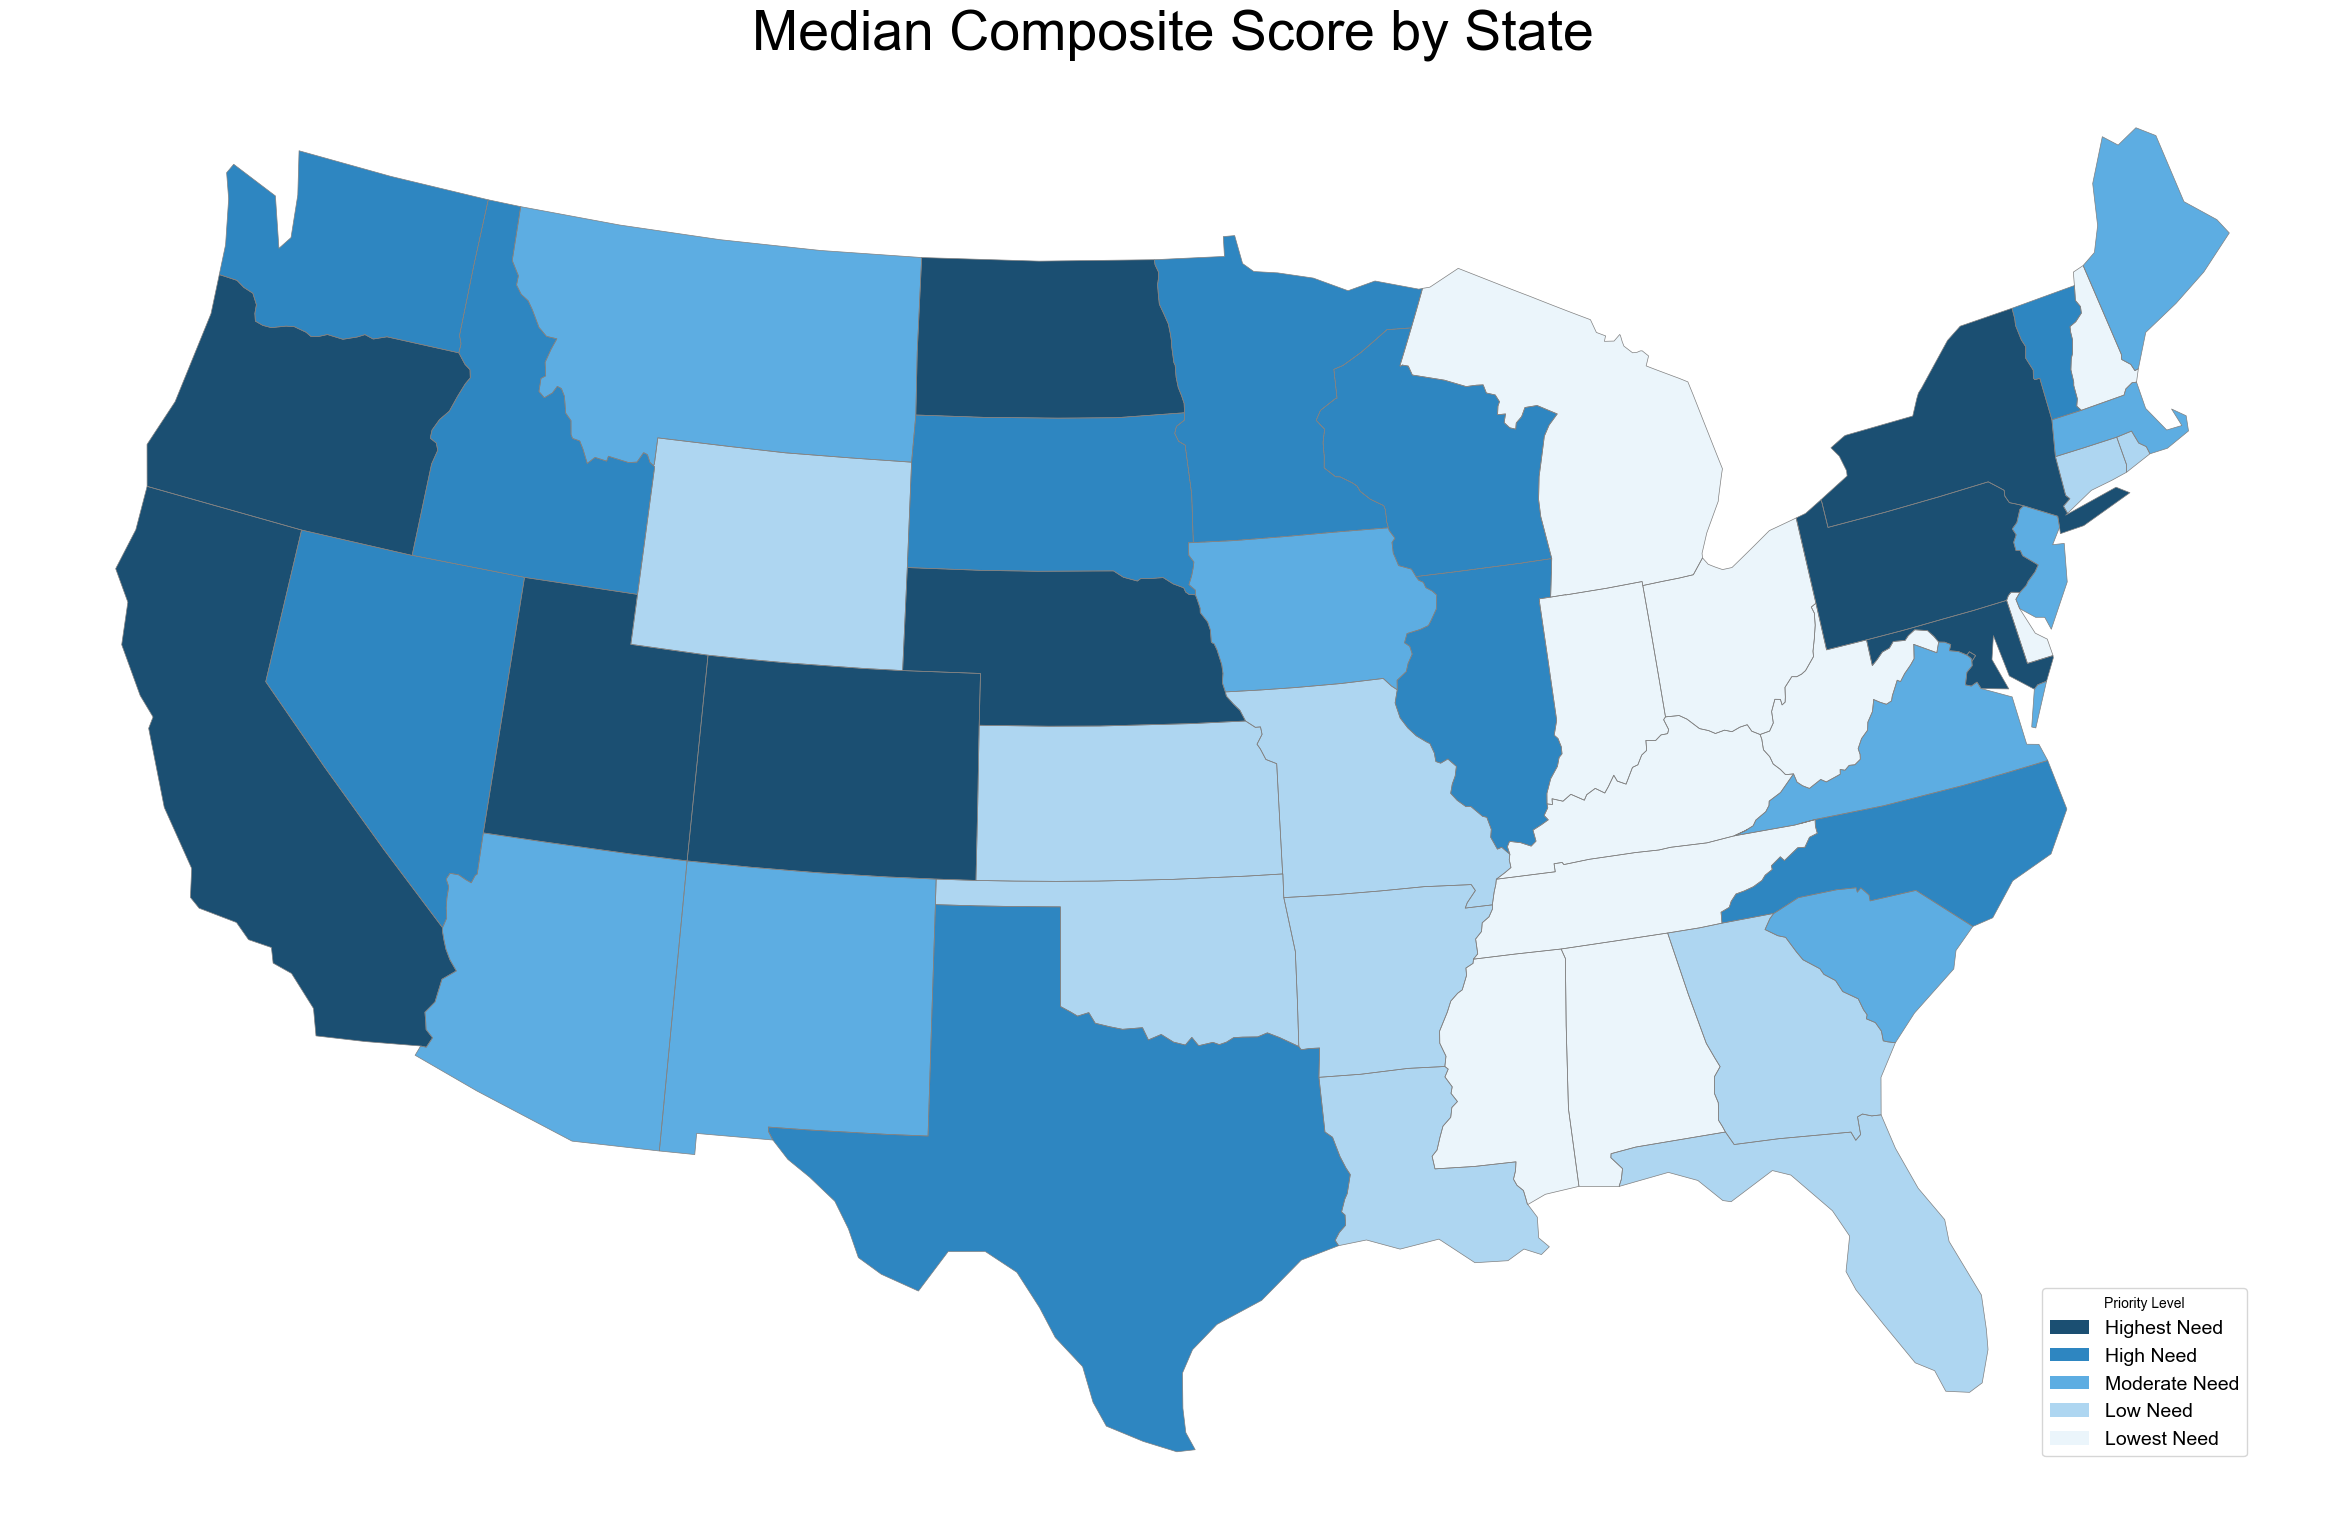

In [133]:
# Create 5 bins based on percentiles (quintiles)
from matplotlib.colors import ListedColormap

legend_labels = [
    'Highest Need',
    'High Need',
    'Moderate Need',
    'Low Need',
    'Lowest Need'
]

bins = [-float('inf'), 
        coverage_df.loc[coverage_df['Percentile'] == 20, 'Score_Threshold'].values[0], 
        coverage_df.loc[coverage_df['Percentile'] == 40, 'Score_Threshold'].values[0], 
        coverage_df.loc[coverage_df['Percentile'] == 60, 'Score_Threshold'].values[0], 
        coverage_df.loc[coverage_df['Percentile'] == 80, 'Score_Threshold'].values[0], 
        float('inf')]

print(bins)

# Create categorical variable based on bins
continental_states_copy['score_category'] = pd.cut(
    continental_states_copy['median_composite_score'], 
    bins=bins,
    labels=legend_labels,
    include_lowest=True
)

colors = ['#EBF5FB', '#AED6F1', '#5DADE2', '#2E86C1', '#1B4F72']  
colors.reverse()

custom_cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(30,20))

# Create choropleth
continental_states_copy.to_crs(epsg_2163).plot(column='median_composite_score',
                ax=ax,
                cmap=custom_cmap,  
                legend=True,
                legend_kwds={
                    'title': 'Priority Level',
                    'labels': legend_labels,
                    'bbox_to_anchor': (0.87, 0.1),
                    'handles': [plt.Rectangle((0,0),1,1, facecolor=color) for color in colors],
                    'loc': 'center left',
                    'fontsize': 14

                },
                categorical=True,
                missing_kwds={'color': 'lightgrey'})

ax.set_title('Median Composite Score by State', fontsize=40)

# Add state boundaries
states[~states.name.isin(['Hawaii', 'Alaska'])].to_crs(epsg_2163).boundary.plot(ax=ax, color='gray', linewidth=0.5)
ax.axis('off')
plt.show()

## Entire US – Median Composite Score by State

This map below is created to show the entire US. It is not going to be used during the presentation.

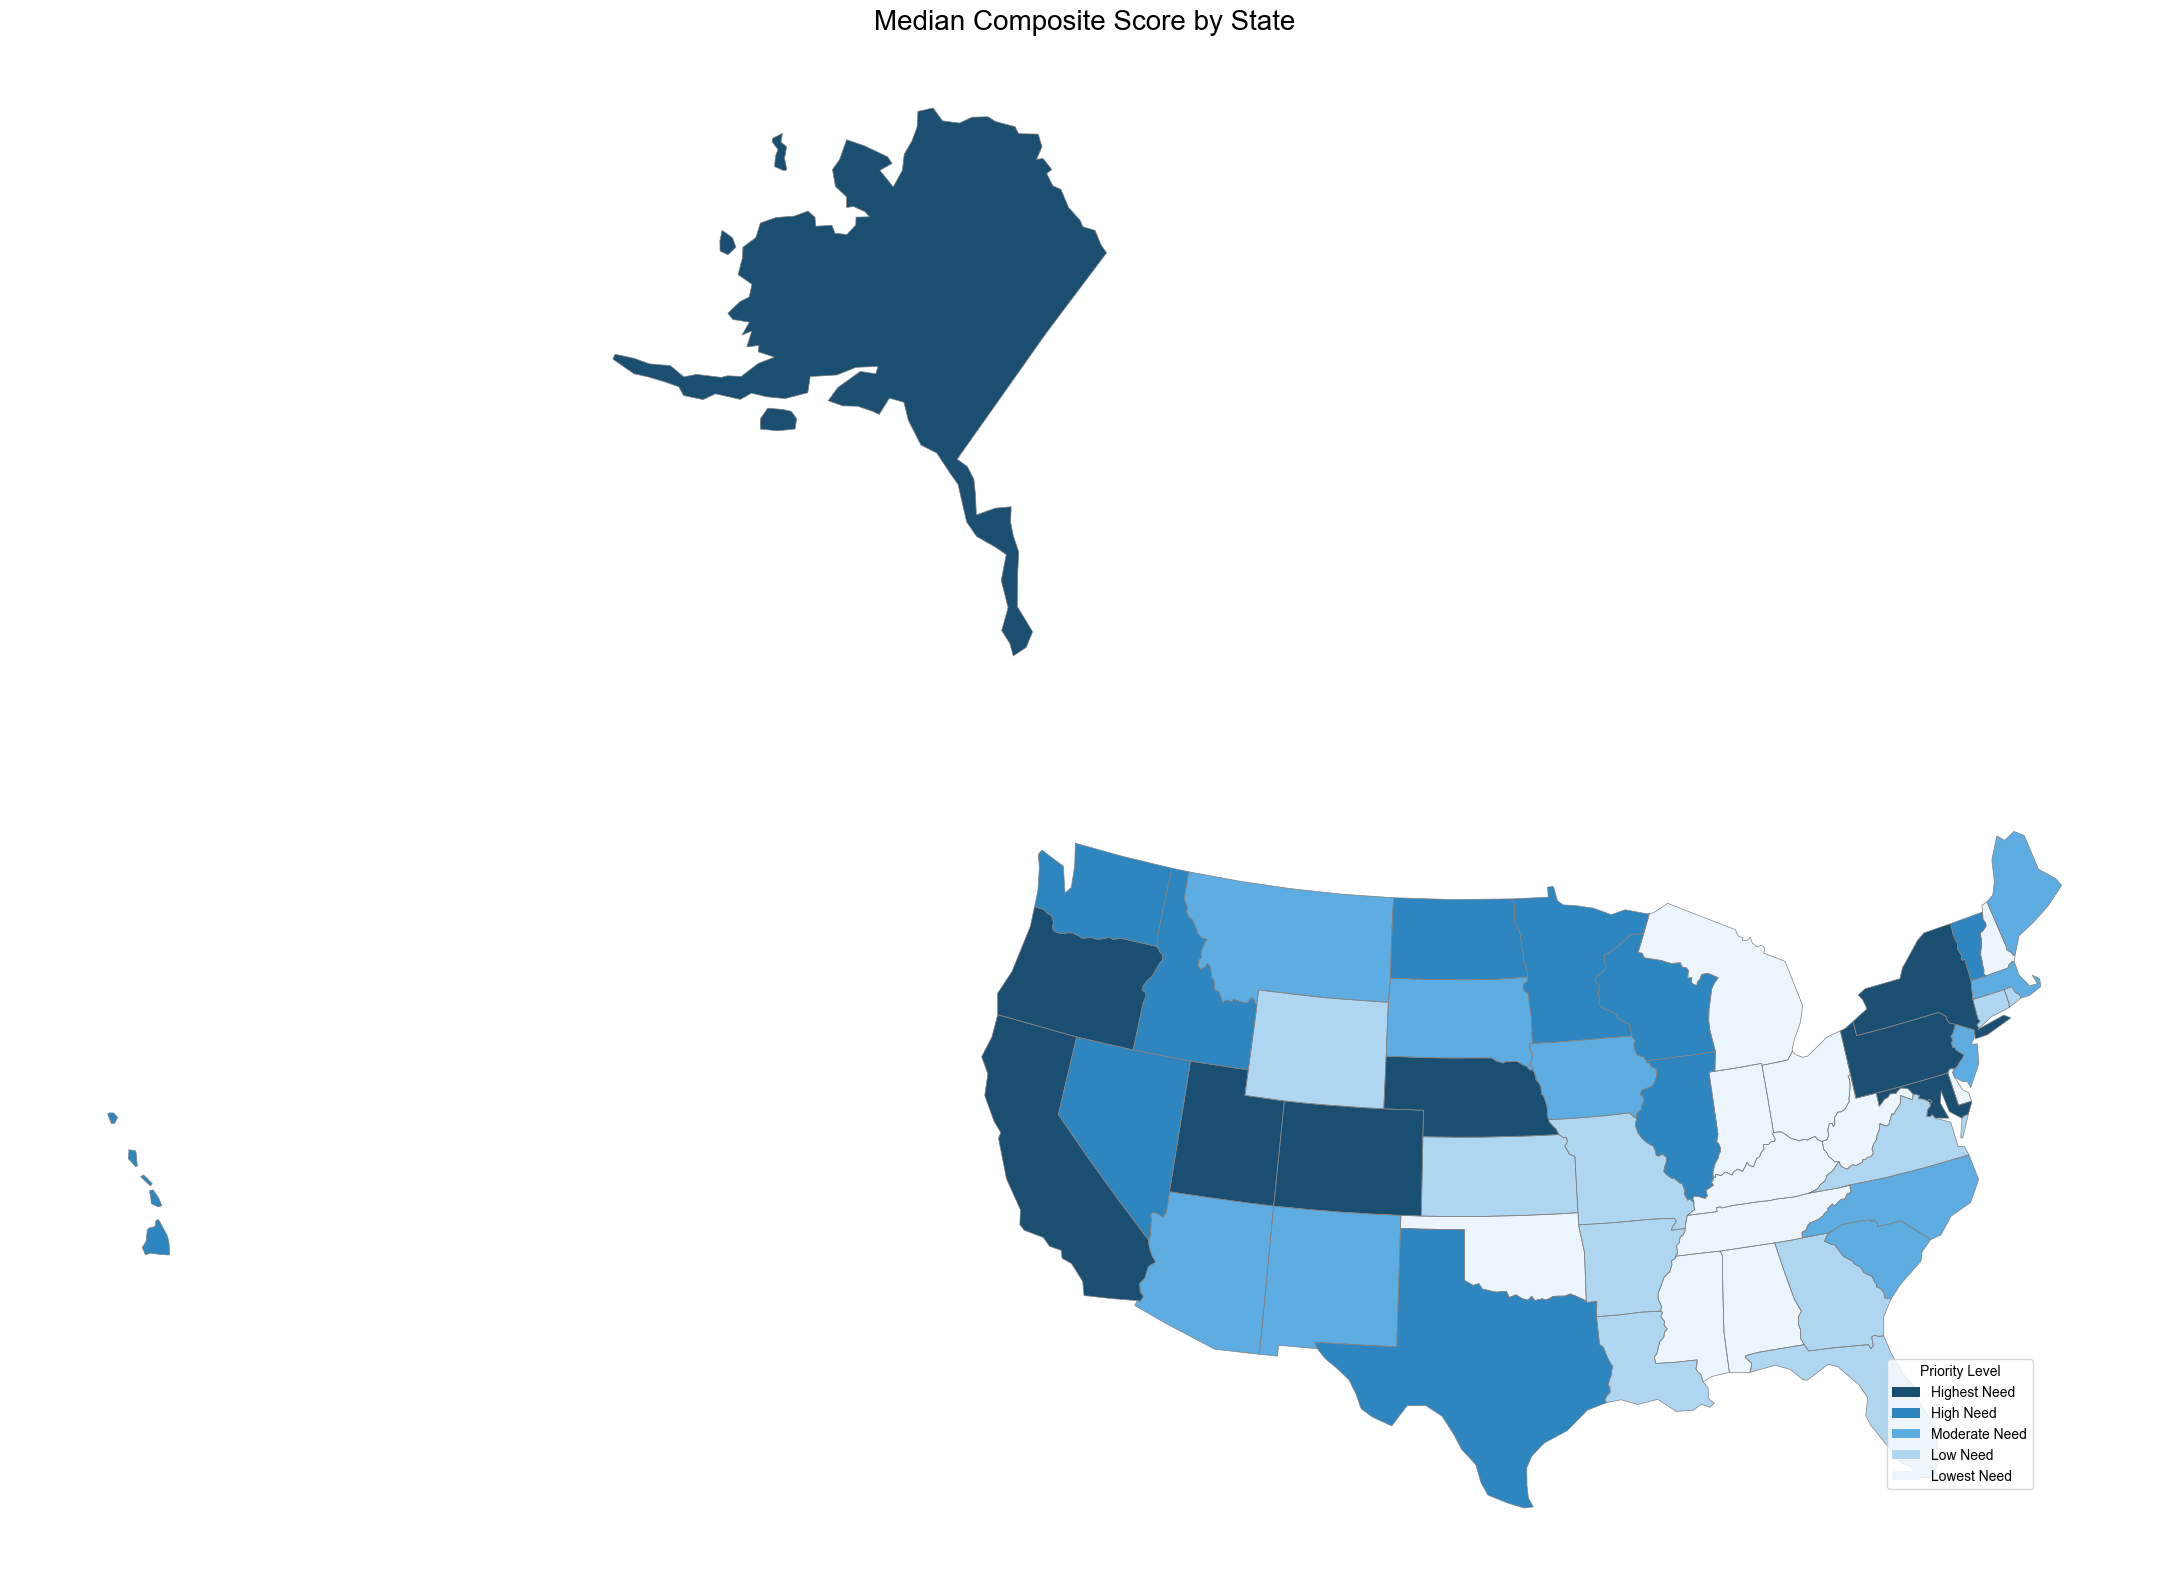

In [134]:
# instead of visualizing the census tracts, we can visualize the average composite score by state 

# Create map with median composite score by state

fig, ax = plt.subplots(figsize=(30,20))

# # Create choropleth
state_scores_gdf.to_crs(epsg_2163).plot(column='median_composite_score',
                ax=ax,
                cmap=custom_cmap,  
                legend=True,
                legend_kwds={
                    'title': 'Priority Level',
                    'labels': legend_labels,
                    'bbox_to_anchor': (0.87, 0.1),
                    'handles': [plt.Rectangle((0,0),1,1, facecolor=color) for color in colors],
                    'loc': 'center left'
                },
                categorical=True,
                missing_kwds={'color': 'lightgrey'})

ax.set_title('Median Composite Score by State', fontsize=20)

states.to_crs(epsg_2163).boundary.plot(ax=ax, color='gray', linewidth=0.5)
ax.axis('off')
plt.show()

## Dual y-axis coverage by percentile (on low access seniors and cities)

In [96]:
coverage_df['Seniors_Covered'] = coverage_df['Seniors_Covered'].astype(int)

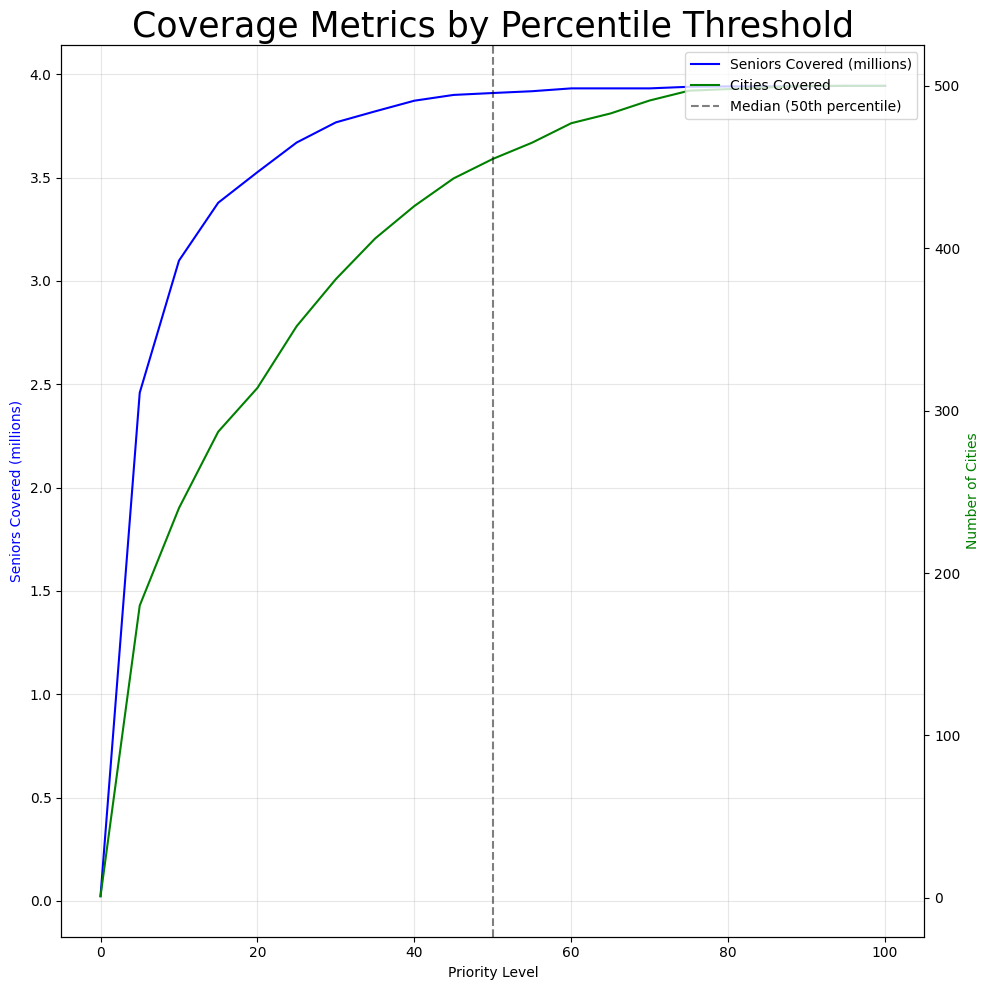

In [97]:
fig, ax1 = plt.subplots(figsize=(10, 10))

# Create second y-axis
ax2 = ax1.twinx()

# Plot lines
ax1.plot(coverage_df['reversed_percentile'], coverage_df['Seniors_Covered']/1000000, 
         color='blue', label='Seniors Covered (millions)')
ax2.plot(coverage_df['reversed_percentile'], coverage_df['Cities_Covered'],
         color='green', label='Cities Covered')
plt.axvline(x=50, color='black', linestyle='--', alpha=0.5, label='Median (50th percentile)')

# Customize axes
ax1.set_xlabel('Priority Level')
ax1.set_ylabel('Seniors Covered (millions)', color='blue')
ax2.set_ylabel('Number of Cities', color='green')

# Add grid
ax1.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Title
plt.title('Coverage Metrics by Percentile Threshold', fontsize=25)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Coverage expansion bar chart for nontechnical audience

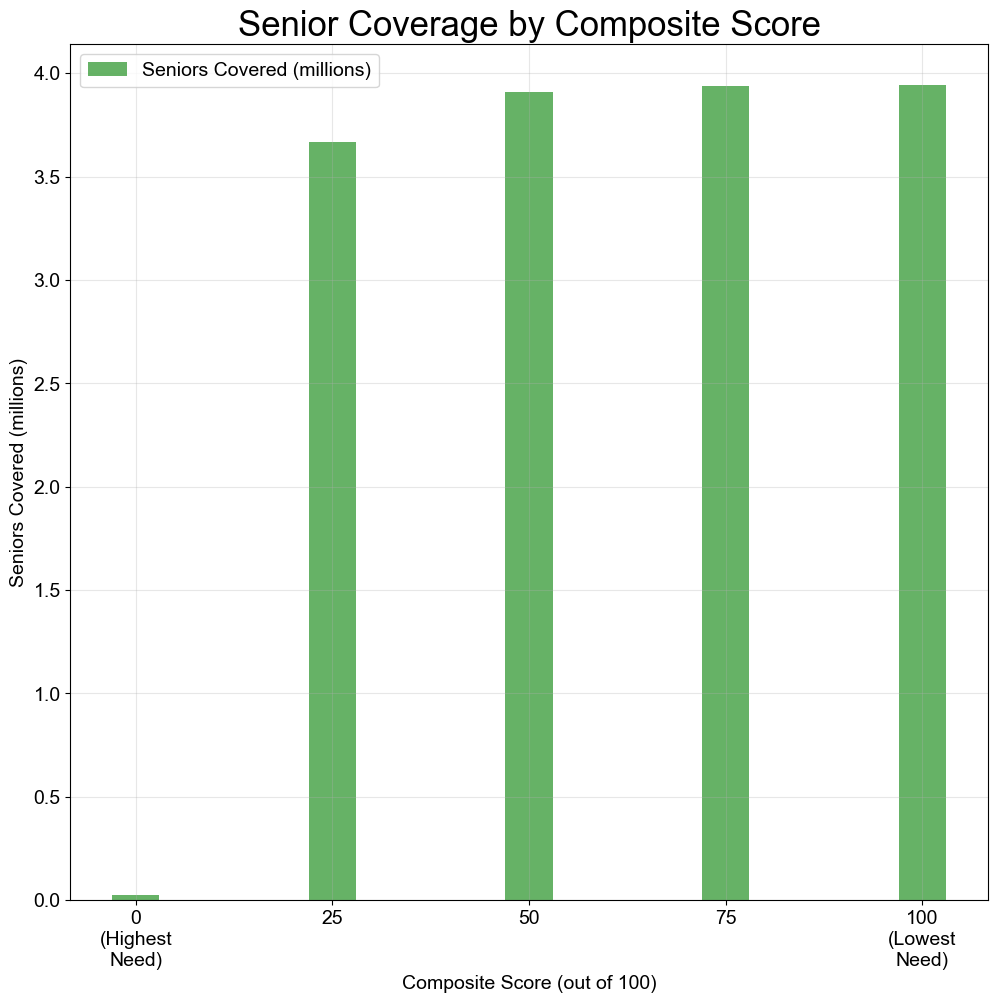

In [138]:
plt.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots(figsize=(10, 10))

key_percentiles = [0, 25, 50, 75, 100]
threshold_data = coverage_df[coverage_df['reversed_percentile'].isin(key_percentiles)]

# Create bar chart for seniors covered
bars = ax.bar(threshold_data['reversed_percentile'] , 
              threshold_data['Seniors_Covered']/1000000,
              color='green',
              alpha=0.6,
              width=6) 

# Add vertical line for median
# plt.axvline(x=50, color='black', linestyle='--', alpha=0.5, label='Median (50th percentile)')

# Customize axes
plt.xticks(key_percentiles, ['0\n(Highest\nNeed)', '25', '50', '75', '100\n(Lowest\nNeed)'])

plt.xlabel('Composite Score (out of 100)', fontsize=14)
plt.ylabel('Seniors Covered (millions)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.legend(['Seniors Covered (millions)'], fontsize = 14)

# Title
plt.title('Senior Coverage by Composite Score', fontsize=25)

# Adjust layout
plt.tight_layout()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()


The program will target the bottom 50th percentile of census tracts which are receiving a composite score below 0, which indicates low access amongst elderly (and low income and people with no cars) as well as poor health markers (including COPD, Heart Disease, Arthitis). At this goal, the program will reach areas with approximately 350 million seniors and 410 cities.